In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

In [ ]:
# Load the dataset
file_path = '/content/environmental conditions.csv'
data = pd.read_csv(file_path)

In [ ]:
# Preprocessing
# Convert 'date' to datetime and extract features
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [ ]:
# Drop the original 'date' column
data.drop(columns=['date'], inplace=True)

In [ ]:
# Encode the target variable
pythium_encoder = LabelEncoder()
data['pythium_probability'] = pythium_encoder.fit_transform(data['pythium_probability'])


In [ ]:
# Encode 'city_name'
city_encoder = LabelEncoder()
data['city_name'] = city_encoder.fit_transform(data['city_name'])

In [ ]:
# Define features and target variable
X = data.drop(columns=['pythium_probability'])
y = data['pythium_probability']

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       186

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [ ]:
# Cross-Validation for Accuracy
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

Cross-Validation Accuracy Scores: [0.99666667 1.         1.         0.99666667 0.99666667]
Mean CV Accuracy: 0.998


In [ ]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", feature_importances)

# Save the model, scaler, and encoders
joblib.dump(model, 'pythium_outbreak_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pythium_encoder, 'pythium_encoder.pkl')
joblib.dump(city_encoder, 'city_encoder.pkl')


Feature Importances:
                     Feature  Importance
2              humidity (%)    0.625386
1  temperature_2m_mean (°C)    0.284878
0                 city_name    0.032007
5                     month    0.019909
3     light_intensity (lux)    0.016092
6                       day    0.012296
4                      year    0.009433


['city_encoder.pkl']

<ipython-input-104-dabd05bf8473>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='viridis')


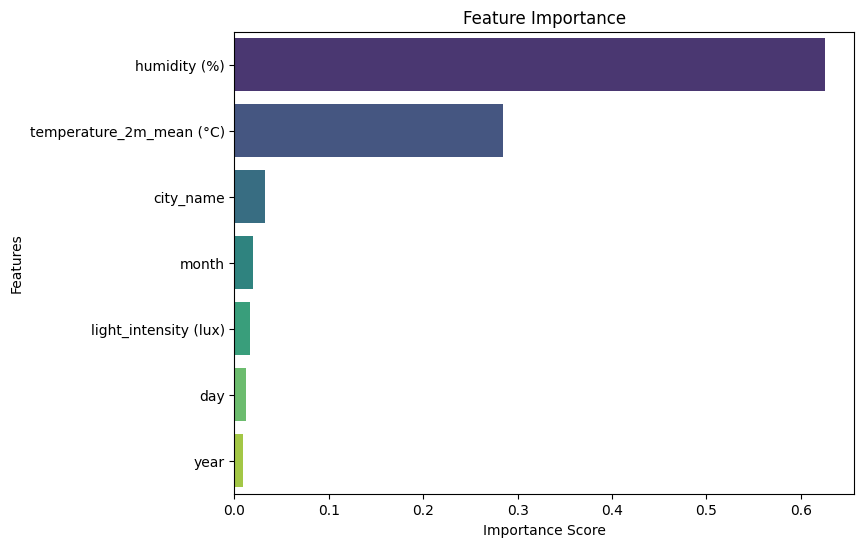

In [ ]:
# 1. Feature Importance Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

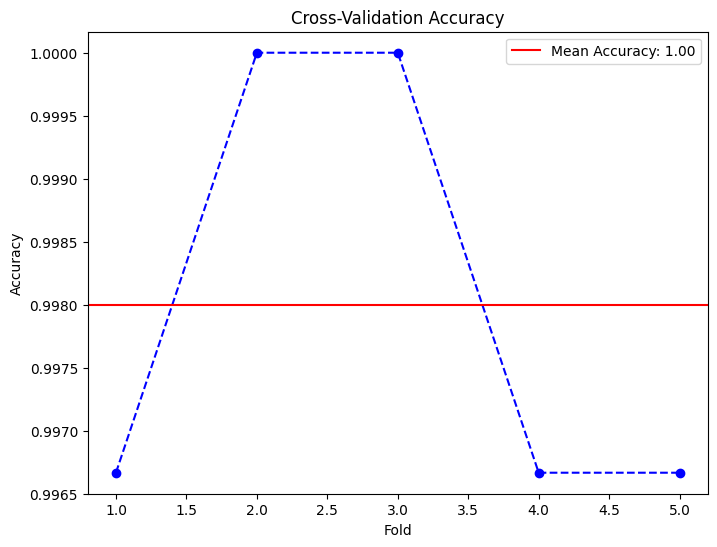

In [ ]:
# 4. Accuracy Visualization (Cross-Validation)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='b')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='-', label=f'Mean Accuracy: {cv_scores.mean():.2f}')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Save the model and scaler
joblib.dump(model, 'pythium_outbreak_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [ ]:
def predict_upcoming_outbreaks(city_name, start_date, end_date):
    # Load the saved model, scaler, and encoders
    model = joblib.load('pythium_outbreak_model.pkl')
    scaler = joblib.load('scaler.pkl')
    pythium_encoder = joblib.load('pythium_encoder.pkl')
    city_encoder = joblib.load('city_encoder.pkl')

    # Check if the city is in the encoder's classes
    if city_name not in city_encoder.classes_:
        # Add the new city to the encoder's classes
        city_encoder.classes_ = np.append(city_encoder.classes_, city_name)

    # Encode the city name
    city_encoded = city_encoder.transform([city_name])[0]

    # Generate a range of dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Create synthetic environmental data (customize ranges as needed)
    future_data = pd.DataFrame({
        'city_name': [city_encoded] * len(dates),
        'temperature_2m_mean (°C)': np.random.uniform(20, 30, len(dates)),
        'humidity (%)': np.random.uniform(60, 90, len(dates)),
        'light_intensity (lux)': np.random.randint(8000, 15000, len(dates)),
        'year': dates.year,
        'month': dates.month,
        'day': dates.day,
    })

    # Standardize the features
    X_future_scaled = scaler.transform(future_data)

    # Predict Pythium probability
    future_predictions = model.predict(X_future_scaled)

    # Decode the predictions using the correct encoder
    future_data['pythium_probability'] = pythium_encoder.inverse_transform(future_predictions)

    # Save predictions to a file
    future_data.to_csv('upcoming_pythium_predictions.csv', index=False)
    print("Predictions saved to 'upcoming_pythium_predictions.csv'.")
    return future_data


In [ ]:
city = "Colombo"
start_date = "2025-01-01"
end_date = "2025-03-31"
predicted_outbreaks = predict_upcoming_outbreaks(city, start_date, end_date)
print(predicted_outbreaks.head())


Predictions saved to 'upcoming_pythium_predictions.csv'.
   city_name  temperature_2m_mean (°C)  humidity (%)  light_intensity (lux)  \
0          5                 21.672257     67.493795                   9493   
1          5                 22.886248     85.913866                  12778   
2          5                 22.574121     68.766918                  11227   
3          5                 20.701925     79.868749                   8559   
4          5                 25.417887     88.094728                  11877   

   year  month  day pythium_probability  
0  2025      1    1              Medium  
1  2025      1    2                High  
2  2025      1    3              Medium  
3  2025      1    4                High  
4  2025      1    5                High  
